In [1]:
!pip install google-auth google-auth-oauthlib google-auth-httplib2
!pip install demoji
!pip install pandas
!pip install langdetect

In [2]:
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
import pandas as pd
import demoji
from langdetect import detect
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
import re   # regular expression
from textblob import TextBlob
from sklearn import metrics
# from mlxtend.plotting import plot_confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
import string
import pickle 
import joblib
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
# from google.colab import drive

In [9]:
from sklearn.model_selection import train_test_split

In [3]:
CLIENT_SECRETS_FILE = "client_secret.json"
SCOPES = ['https://www.googleapis.com/auth/youtube.force-ssl']
API_SERVICE_NAME = 'youtube'
API_VERSION = 'v3'

In [4]:
def get_authenticated_service():
    flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
    credentials = flow.run_console()
    return build(API_SERVICE_NAME, API_VERSION, credentials = credentials)

In [5]:
# drive.mount('/content/drive')
# os.chdir('/content/drive/My Drive/Colab Notebooks/Youtube API')
# os.environ['OAUTHLIB_INSECURE_TRANSPORT'] = '1'
service = get_authenticated_service()

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=1069387478686-rmblc2j43mb948377962a464m2k83p07.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.force-ssl&state=wSFujmZlHuAXGUI2KSnjb4LcQqac1s&prompt=consent&access_type=offline


Enter the authorization code:  4/5AEkvClrWRbtJbo-IQ9SWiMBarUsXA-_Z3XWwfd4AbMFR0JA2_4eQ0g


In [6]:
query = "Coronavirus: Canadian students head back to school in anxious, uncertain times"

PIPLINE ==========================

In [7]:
query_results = service.search().list(part = 'snippet',q = query,
                                      order = 'relevance', 
                                      type = 'video',
                                      relevanceLanguage = 'en',
                                      safeSearch = 'moderate').execute()

video_id = []
channel = []
video_title = []
video_desc = []
for item in query_results['items']:
    video_id.append(item['id']['videoId'])
    channel.append(item['snippet']['channelTitle'])
    video_title.append(item['snippet']['title'])
    video_desc.append(item['snippet']['description'])


video_id = video_id[0]
channel = channel[0]
video_title = video_title[0]
video_desc = video_desc[0]



video_id_pop = []
channel_pop = []
video_title_pop = []
video_desc_pop = []
comments_pop = []
comment_id_pop = []
reply_count_pop = []
like_count_pop = []


comments_temp = []
comment_id_temp = []
reply_count_temp = []
like_count_temp = []


nextPage_token = None

while 1:
    response = service.commentThreads().list(
                    part = 'snippet',
                    videoId = video_id,
                    maxResults = 100, 
                    order = 'relevance', 
                    textFormat = 'plainText',
                    pageToken = nextPage_token
                    ).execute()


    nextPage_token = response.get('nextPageToken')
    for item in response['items']:
        comments_temp.append(item['snippet']['topLevelComment']['snippet']['textDisplay'])
        comment_id_temp.append(item['snippet']['topLevelComment']['id'])
        reply_count_temp.append(item['snippet']['totalReplyCount'])
        like_count_temp.append(item['snippet']['topLevelComment']['snippet']['likeCount'])
        comments_pop.extend(comments_temp)
        comment_id_pop.extend(comment_id_temp)
        reply_count_pop.extend(reply_count_temp)
        like_count_pop.extend(like_count_temp)

        video_id_pop.extend([video_id]*len(comments_temp))
        channel_pop.extend([channel]*len(comments_temp))
        video_title_pop.extend([video_title]*len(comments_temp))
        video_desc_pop.extend([video_desc]*len(comments_temp))

    if nextPage_token is  None:
        break
    

output_dict = {
       'Channel': channel_pop,
        'Video Title': video_title_pop,
        'Video Description': video_desc_pop,
        'Video ID': video_id_pop,
        'Comment': comments_pop,
        'Comment ID': comment_id_pop,
        'Replies': reply_count_pop,
        'Likes': like_count_pop,
        }

output_df = pd.DataFrame(output_dict, columns = output_dict.keys())


duplicates = output_df[output_df.duplicated("Comment ID")]


unique_df = output_df.drop_duplicates(subset=['Comment'])

comments = unique_df

demoji.download_codes()

comments['clean_comments'] = comments['Comment'].apply(lambda x: demoji.replace(x,""))

comments['language'] = 0

count = 0
for i in range(0,len(comments)):
    temp = comments['clean_comments'].iloc[i]
    count += 1
    try:
        comments['language'].iloc[i] = detect(temp)
    except:
        comments['language'].iloc[i] = "error"


comments[comments['language']=='en']['language'].value_counts()

english_comm = comments[comments['language'] == 'en']

en_comments = english_comm

regex = r"[^0-9A-Za-z'\t]"

copy = en_comments.copy()


copy['reg'] = copy['clean_comments'].apply(lambda x:re.findall(regex,x))
copy['regular_comments'] = copy['clean_comments'].apply(lambda x:re.sub(regex,"  ",x))


dataset = copy[['Video Title','Video ID','Comment ID','Replies','Likes','regular_comments']].copy()


dataset = dataset.rename(columns = {"regular_comments":"comments"})

... OK (Got response in 0.20 seconds)
Writing emoji data to /Users/maryam/.demoji/codes.json ...
... OK


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

SENTIMENTAL ANALYSIS

In [19]:
data = dataset


data['polarity'] = data['comments'].apply(lambda x: TextBlob(x).sentiment.polarity)

data = data.sample(frac=1).reset_index(drop=True)

data['pol_cat']  = 0

data['pol_cat'][data.polarity > 0] = 1
data['pol_cat'][data.polarity <= 0] = -1

data_pos = data[data['pol_cat'] == 1]
data_pos = data_pos.reset_index(drop = True)

data_neg = data[data['pol_cat'] == -1]
data_neg = data_neg.reset_index(drop = True)


data['comments'] = data['comments'].str.lower()


data['comments'][0].strip()


nltk.download("stopwords")
nltk.download("punkt")


stop_words = set(stopwords.words('english'))

data['comments'] = data['comments'].str.strip()

train = data.copy()


def remove_stopwords(line):
    word_tokens = word_tokenize(line)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return " ".join(filtered_sentence)




data['stop_comments'] = data['comments'].apply(lambda x : remove_stopwords(x))

X_train,X_test,y_train,y_test = train_test_split(data['stop_comments'],data['pol_cat'],test_size = 0.2,random_state = 324)
vect = CountVectorizer()
tf_train = vect.fit_transform(X_train)
tf_test = vect.transform(X_test)



print(vect.vocabulary_)

vocab = vect.vocabulary_



from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(tf_train,y_train)





predicted = lr.predict(tf_t)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maryam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/maryam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/opt/anaconda3/lib/python3

{'online': 1286, 'schooling': 1588, 'fine': 704, 'idea': 913, 'kids': 1009, 'would': 2054, 'log': 1091, '9am': 57, 'able': 60, 'see': 1601, 'teacher': 1811, 'like': 1065, 'classroom': 361, 'taught': 1808, 'home': 888, 'computer': 402, 'oh': 1278, 'covid': 444, 'keeps': 1004, 'spreading': 1714, 'meanwhile': 1150, 'death': 487, 'rate': 1455, 'gone': 799, 'admit': 82, 'seasonal': 1597, 'flu': 717, 'stop': 1739, 'talking': 1801, 'already': 106, 'elaborate': 600, 'hoax': 884, 'everybody': 636, 'half': 831, 'brain': 245, 'knows': 1022, 'lying': 1112, 'heys': 870, 'guys': 827, 'get': 775, 'haha': 829, 'report': 1500, 'bad': 177, 'behaviour': 202, 'mean': 1148, 'people': 1341, 'trying': 1915, 'return': 1523, 'normal': 1253, 'life': 1064, 'say': 1575, 'else': 604, 'yea': 2064, 'sound': 1695, 'fascist': 679, 'nieces': 1247, 'nephews': 1235, 'saint': 1560, 'petersburg': 1351, 'florida': 716, 'ca': 282, 'wait': 1977, 'move': 1202, 'new': 1240, 'brunswick': 267, 'go': 790, 'class': 358, 'school': 1

In [11]:
# Accuracy score on training dataset
lr.score(tf_train,y_train)

0.9968652037617555

In [15]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


In [20]:
!pip install mlxtend

[[121   1]
 [  0 197]]


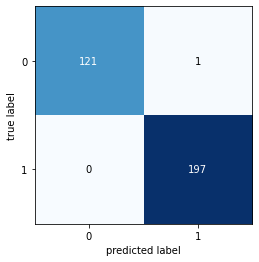

In [21]:
expected = y_train
cf = metrics.confusion_matrix(expected,predicted,labels = [1,-1])
print(cf)

## this command is only for google collab 
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
fig, ax = plot_confusion_matrix(conf_mat = cf)
                                
## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

In [52]:
data_pos =0
data_neg = 0

for i in range(0,len(predicted)):
    if (predicted[i] == 1):
        data_pos = data_pos + 1
    else:
        data_neg = data_neg + 1


if (data_pos)>= (data_neg):
    print ("Positive comments are more than negetive comments")
elif (data_pos)== (data_neg):
    print ("positive comments and Negetive comments are equal ")
else:
    print("Negetive comments are more than Positive comments")        
        
        
# if (data_pos)>= (len(predicted)/3):
#     print ("Positive comments")
# elif (data_pos)== (len(predicted)/2):
#     print ("Not positive and Not negetive comments")
# else:
#     print("Negetive comments")

Negetive comments are more than Positive comments


In [22]:
len(predicted)

319

In [24]:
# save model
lr = lr
Pkl_Filename = "lr.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(lr, file)
#...

# save vect
vect = vect
Pkl_Filename = "vect.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(vect, file)
#...



In [54]:
!pip3 install nbconvert

You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [ ]:
!pip install ipython

In [ ]:
!jupyter nbconvert 'Youtube comment analysis.ipynb' --to script 